In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch

In [2]:
sudoku1 = pd.read_csv("sudoku1.csv", delimiter="\t", header=None)
sudoku2 = pd.read_csv("sudoku2.csv", delimiter="\t", header=None)

# Select only EEG channels (columns 1 to 8?)
eeg_channels = list(range(1, 9))
sudoku1_eeg = sudoku1.iloc[:, eeg_channels]
sudoku2_eeg = sudoku2.iloc[:, eeg_channels]

sudoku1_eeg = sudoku1_eeg.apply(pd.to_numeric)
sudoku2_eeg = sudoku2_eeg.apply(pd.to_numeric)
print(sudoku1_eeg.head())
print(sudoku2_eeg.head())


             1             2             3             4             5  \
0     0.000000      0.000000      0.000000      0.000000      0.000000   
1  8913.562764  17400.631893  23271.362277  20163.173397  24611.349358   
2  8040.235405  16512.999417  22380.265281  19266.846093  23718.508925   
3  6743.811875  15223.259058  21090.748440  17974.468228  22431.271962   
4  7412.531365  15905.166078  21768.945070  18651.234347  23118.118717   

              6             7             8  
0      0.000000      0.000000      0.000000  
1  11486.784993  19364.746733  14552.572614  
2  10587.261389  18475.370821  13660.022755  
3   9301.432586  17191.084288  12371.064707  
4   9999.812841  17878.579244  13050.982422  
              1             2             3             4             5  \
0      0.000000      0.000000      0.000000      0.000000      0.000000   
1  42721.783247  52654.205579  55896.057891  53493.692397  57934.358172   
2  41551.356501  51484.672902  54724.535909  52322.729

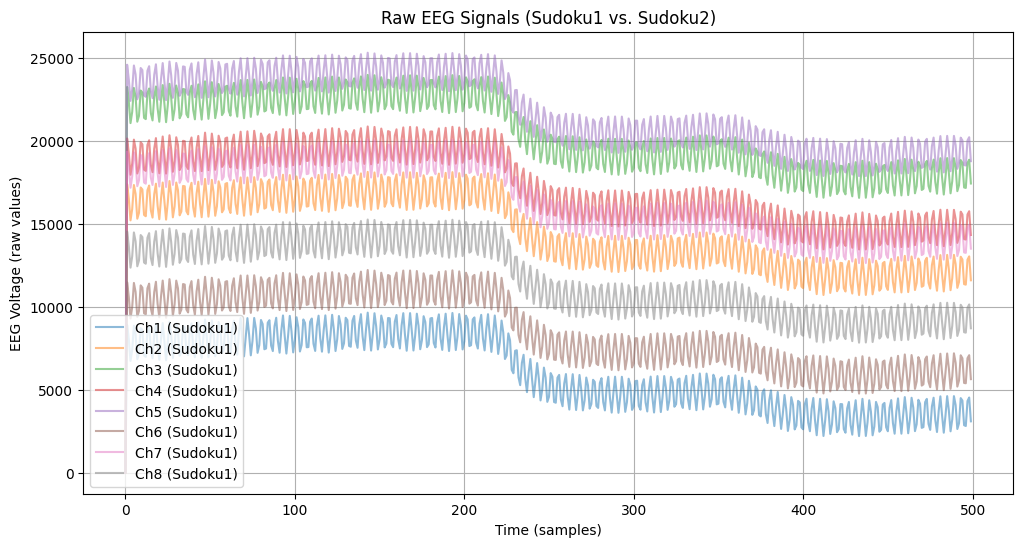

In [ ]:
# Plot raw EEG signals for Sudoku1
plt.figure(figsize=(12, 6))
for i in range(8):  # 8 channels (Ch1 - Ch8)
    plt.plot(sudoku1_eeg.iloc[:500, i], label=f"Ch{i+1} (Sudoku1)", alpha=0.5)
plt.xlabel("Time (samples)")
plt.ylabel("EEG Voltage (raw values)")
plt.title("Raw EEG Signals (Sudoku1)")
plt.legend()
plt.grid()
plt.show()

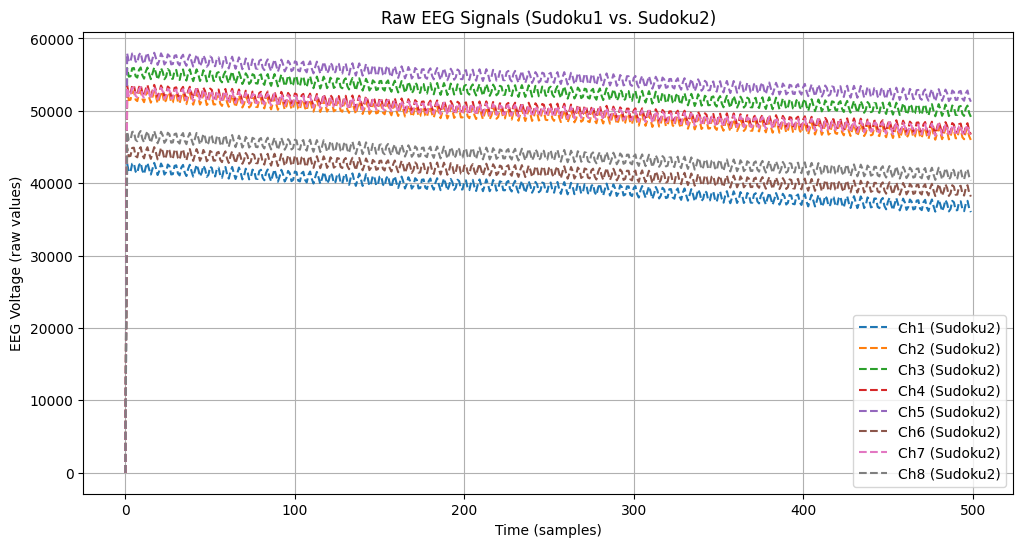

In [ ]:
# Plot raw EEG signals for Sudoku2
plt.figure(figsize=(12, 6))
for i in range(8):  # 8 channels (Ch1 - Ch8)
    plt.plot(sudoku2_eeg.iloc[:500, i], label=f"Ch{i+1} (Sudoku2)", linestyle="dashed")
plt.xlabel("Time (samples)")
plt.ylabel("EEG Voltage (raw values)")
plt.title("Raw EEG Signals (Sudoku2)")
plt.legend()
plt.grid()
plt.show()

In [5]:
# Define a bandpass filter function
def bandpass_filter(data, lowcut=0.1, highcut=30, fs=250, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

# Apply bandpass filter to EEG data
sudoku1_filtered = bandpass_filter(sudoku1_eeg, lowcut=0.1, highcut=30, fs=250)
sudoku2_filtered = bandpass_filter(sudoku2_eeg, lowcut=0.1, highcut=30, fs=250)

In [6]:
# Define EEG frequency bands
bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta": (12, 30)
}

fs = 250  # Sampling frequency
psd_values = {}

# Compute PSD for each frequency band
for band, (low, high) in bands.items():
    idx_band = np.where((np.linspace(0, fs/2, num=128) >= low) & (np.linspace(0, fs/2, num=128) <= high))
    psd_values[band] = {}

    for i, col in enumerate(eeg_channels):  # Iterate over correct EEG channels
        freqs, psd1 = welch(sudoku1_filtered[:, i], fs=fs, nperseg=fs*2)
        freqs, psd2 = welch(sudoku2_filtered[:, i], fs=fs, nperseg=fs*2)

        psd_values[band][f"Ch{i+1}"] = {
            "Sudoku1": np.mean(psd1[idx_band]),
            "Sudoku2": np.mean(psd2[idx_band])
        }

psd_df = pd.DataFrame(psd_values)
print(psd_df)

                                                 Delta  \
Ch1  {'Sudoku1': 2941610.2427469282, 'Sudoku2': 272...   
Ch2  {'Sudoku1': 2951607.721399595, 'Sudoku2': 2757...   
Ch3  {'Sudoku1': 2953248.618429474, 'Sudoku2': 2764...   
Ch4  {'Sudoku1': 2949621.7661259403, 'Sudoku2': 275...   
Ch5  {'Sudoku1': 2958264.51934012, 'Sudoku2': 27749...   
Ch6  {'Sudoku1': 2942549.1182741313, 'Sudoku2': 272...   
Ch7  {'Sudoku1': 2945775.3284209236, 'Sudoku2': 275...   
Ch8  {'Sudoku1': 2942752.4734707545, 'Sudoku2': 273...   

                                                 Theta  \
Ch1  {'Sudoku1': 33106.8422680204, 'Sudoku2': 35483...   
Ch2  {'Sudoku1': 33110.2573386044, 'Sudoku2': 35515...   
Ch3  {'Sudoku1': 33085.42472371495, 'Sudoku2': 3544...   
Ch4  {'Sudoku1': 33109.894849549884, 'Sudoku2': 354...   
Ch5  {'Sudoku1': 32988.478286385296, 'Sudoku2': 354...   
Ch6  {'Sudoku1': 33126.037352594794, 'Sudoku2': 355...   
Ch7  {'Sudoku1': 33093.446989814656, 'Sudoku2': 354...   
Ch8  {'Sudoku

Feature Differences (Sudoku2 - Sudoku1):
              Delta        Theta      Alpha       Beta
Ch1 -218988.199697  2376.276752  68.061706  45.192627
Ch2 -194294.396209  2404.789736  64.771893  45.430255
Ch3 -188471.854055  2360.193887  58.515469  43.650551
Ch4 -194109.926837  2353.830782  58.483633  42.397927
Ch5 -183363.396089  2417.635709  83.754239  45.358844
Ch6 -214948.816987  2380.095334  68.218746  45.598732
Ch7 -194713.195750  2374.887077  74.490817  45.793677
Ch8 -209531.299556  2345.710636  60.738780  44.307621


C:\Users\tommy\AppData\Local\Temp\ipykernel_23660\3577142030.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  psd_df_numeric = psd_df.applymap(lambda x: x["Sudoku2"] - x["Sudoku1"])


<Figure size 800x500 with 0 Axes>

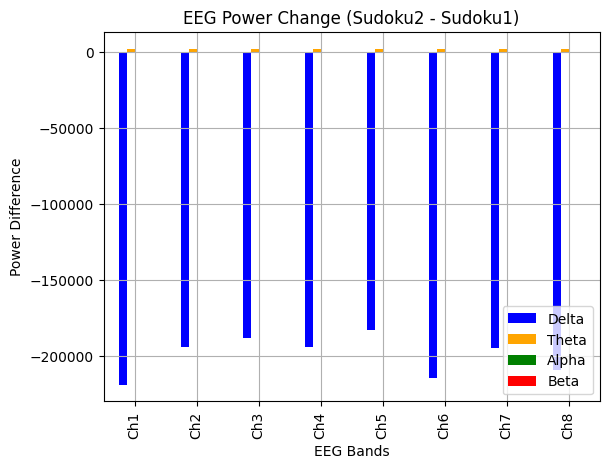

In [7]:
# Extract numeric values from nested dictionaries
psd_df_numeric = psd_df.applymap(lambda x: x["Sudoku2"] - x["Sudoku1"])

# Display feature differences
print("Feature Differences (Sudoku2 - Sudoku1):\n", psd_df_numeric)

# EEG power changes
plt.figure(figsize=(8, 5))
psd_df_numeric.plot(kind='bar', color=['blue', 'orange', 'green', 'red'])
plt.xlabel("EEG Bands")
plt.ylabel("Power Difference")
plt.title("EEG Power Change (Sudoku2 - Sudoku1)")
plt.grid()
plt.show()

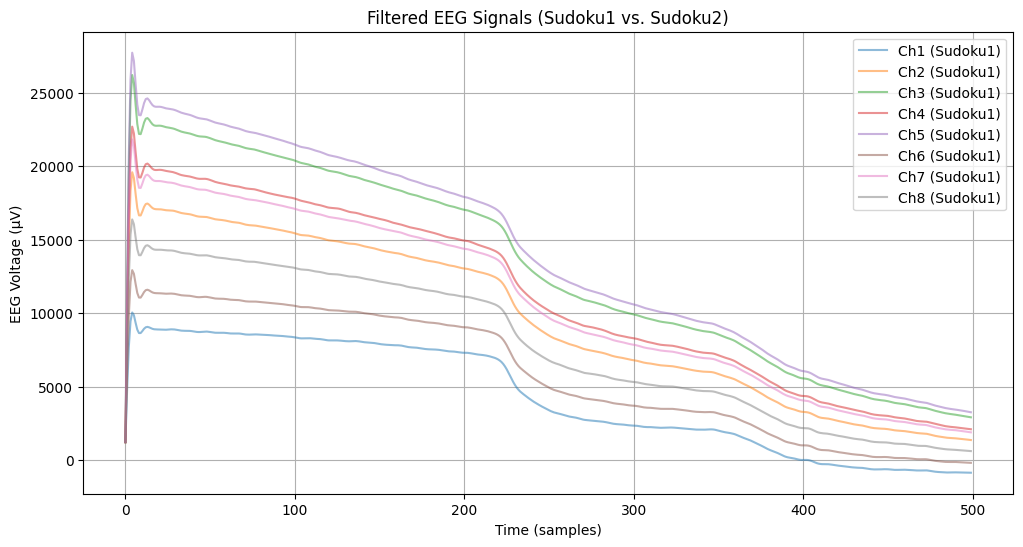

In [ ]:
# Plot EEG signals after bandpass filtering
plt.figure(figsize=(12, 6))

# Plot each EEG channel after filtering
for i in range(8):  # 8 channels (Ch1 - Ch8)
    plt.plot(sudoku1_filtered[:, i][:500], label=f"Ch{i+1} (Sudoku1)", alpha=0.5)
plt.xlabel("Time (samples)")
plt.ylabel("EEG Voltage (µV)")
plt.title("Filtered EEG Signals (Sudoku1)")
plt.legend()
plt.grid()
plt.show()

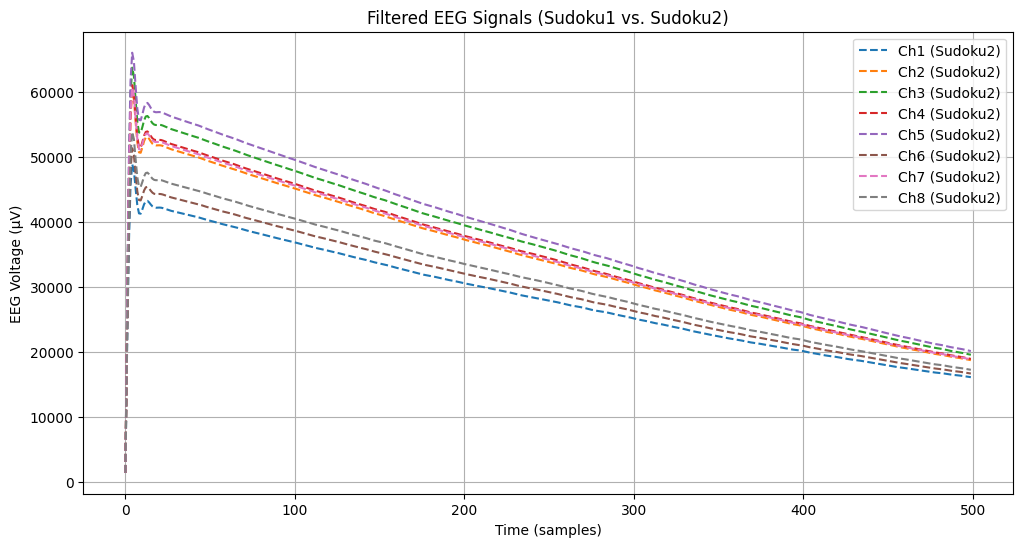

In [ ]:
# Plot EEG signals after bandpass filtering
plt.figure(figsize=(12, 6))

# Plot each EEG channel after filtering
for i in range(8):  # 8 channels (Ch1 - Ch8)
    plt.plot(sudoku2_filtered[:, i][:500], label=f"Ch{i+1} (Sudoku2)", linestyle="dashed")
plt.xlabel("Time (samples)")
plt.ylabel("EEG Voltage (µV)")
plt.title("Filtered EEG Signals (Sudoku2)")
plt.legend()
plt.grid()
plt.show()